In [1]:
import numpy as np
import pandas as pd
import time
import sys
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import pylab as pl
import matplotlib
import seaborn as sns
from datetime import datetime
import os
os.environ["PROJ_LIB"] = "/Users/onurhanaydin/opt/anaconda3/envs/geo_env2/share/basemap/epsg"
from mpl_toolkits.basemap import Basemap, shiftgrid
import PseudoNetCDF as pnc
from PseudoNetCDF import PNC
from PseudoNetCDF.pncparse import pncparse
from PseudoNetCDF.coordutil import gettimes
import pyproj
import pygeos
import xarray as xr
from netCDF4 import Dataset as NetCDFFile 
import icartt as ic
import geopandas as gpd
import fiona
from shapely.geometry import Polygon, Point
from geopy.geocoders import Nominatim
import timeit
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
%matplotlib inline
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 20) 
pd.options.display.float_format = "{:.3f}".format 

path = "/Users/onurhanaydin/Desktop/MSc/2/Regional Climate Processes/Exercises/"

/Users/onurhanaydin/opt/anaconda3/envs/geo_env2/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
nc = NetCDFFile(path+"NWP_LAM_DOM01_20201103T000000Z_0001.nc")
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.8.3rc (http://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    uuidOfVGrid: cc8ed107-aee4-0b0b-30bc-d929e7372ac0
    institution: Max Planck Institute for Meteorology/Deutscher Wetterdienst
    title: ICON simulation
    source: Unknown@Unknown
    history: /home/stud_homes/s4449823/ICON/icon/build/bin/icon at 20220519 133346
    references: see MPIM/DWD publications
    comment: s4449823 (s4449823) on blade5g (Linux 3.10.0-1160.59.1.el7.x86_64 x86_64)
    dimensions(sizes): lon(141), lat(131), lon_2(141), lat_2(131), height(50), bnds(2), height_2(51), plev(1), plev_2(1), plev_3(1), depth(9), depth_2(8), height_3(1), height_4(1), time(2)
    variables(dimensions): float32 lon(lat, lon), float32 lat(lat, lon), float32 lon_2(lon_2), float32 lat_2(lat_2), int32 rotated_pole(), float64 height(height), float64 height_bnds(height, bnds), float64 height

In [4]:
nc.variables

{'lon': <class 'netCDF4._netCDF4.Variable'>
 float32 lon(lat, lon)
     standard_name: longitude
     long_name: longitude
     units: degrees_east
     _CoordinateAxisType: Lon
 unlimited dimensions: 
 current shape = (131, 141)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lat': <class 'netCDF4._netCDF4.Variable'>
 float32 lat(lat, lon)
     standard_name: latitude
     long_name: latitude
     units: degrees_north
     _CoordinateAxisType: Lat
 unlimited dimensions: 
 current shape = (131, 141)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lon_2': <class 'netCDF4._netCDF4.Variable'>
 float32 lon_2(lon_2)
     standard_name: grid_longitude
     units: degrees_east
     axis: X
 unlimited dimensions: 
 current shape = (141,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lat_2': <class 'netCDF4._netCDF4.Variable'>
 float32 lat_2(lat_2)
     standard_name: grid_latitude
     units: degrees_north
     axis: Y
 unlimited dimensions:

/var/folders/2b/jb5zd36n0zj39js1kxhlr3bw0000gn/T/ipykernel_1265/3474662390.py:15: UserWarning: The following kwargs were not used by contour: 'c'
  cf = ax[0].contour(lats, levs, u_mean[:,:,0], c='b')
/var/folders/2b/jb5zd36n0zj39js1kxhlr3bw0000gn/T/ipykernel_1265/3474662390.py:18: UserWarning: The following kwargs were not used by contour: 'c'
  cf = ax[1].contour(lats, levs, u_mean[:,:,1], c='b')


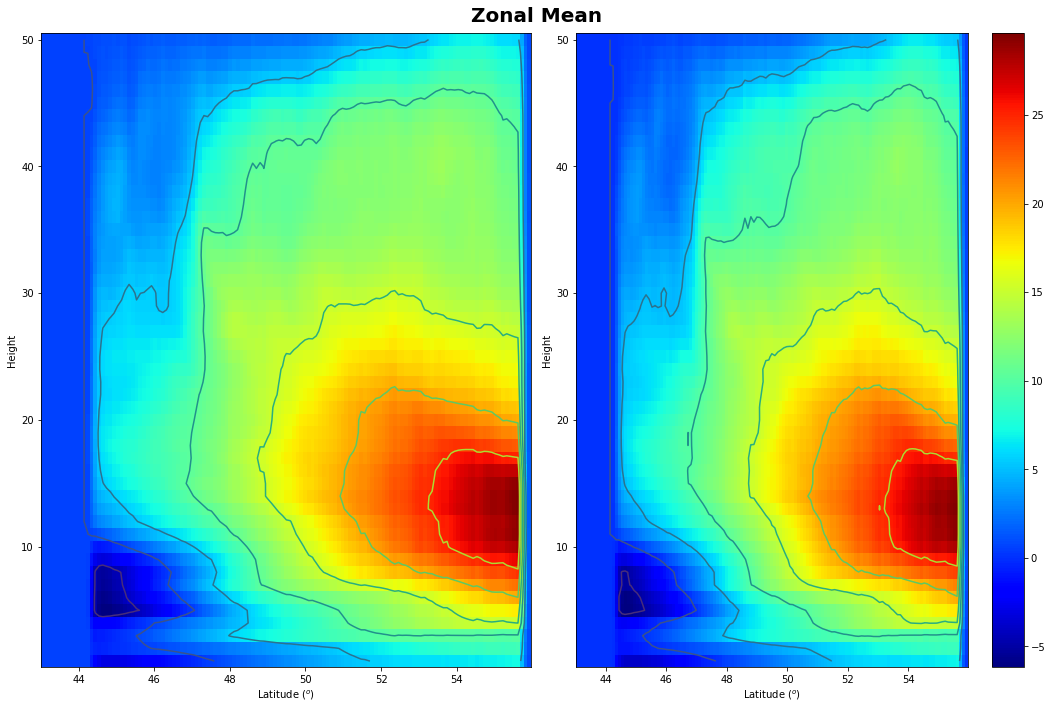

In [141]:
lat = nc.variables['lat'][:,0]
lon = nc.variables['lon'][0,:]
time = nc.variables['time'][:]
h = nc.variables['height'][:]

u = nc.variables['u'][:]      # (time, height, lat, lon) (2, 50, 131, 141)
u_mean   = np.transpose(np.mean(u, axis=3))

fig, ax=plt.subplots(1,2, figsize=(15,10))
fig.suptitle('Zonal Mean', fontsize=20, fontweight="bold")

levs,lats= np.meshgrid(h,lat)

im = ax[0].pcolormesh(lats, levs, u_mean[:,:,0],  cmap='jet')
cf = ax[0].contour(lats, levs, u_mean[:,:,0], c='b')

im = ax[1].pcolormesh(lats, levs, u_mean[:,:,1],  cmap='jet')
cf = ax[1].contour(lats, levs, u_mean[:,:,1], c='b')


fig.colorbar(im, orientation='vertical')
ax[0].set_xlabel('Latitude ($^o$)')
ax[0].set_ylabel('Height')

ax[1].set_xlabel('Latitude ($^o$)')
ax[1].set_ylabel('Height')
fig.tight_layout()
#fig.savefig(path+'zonal mean.png',facecolor='white')

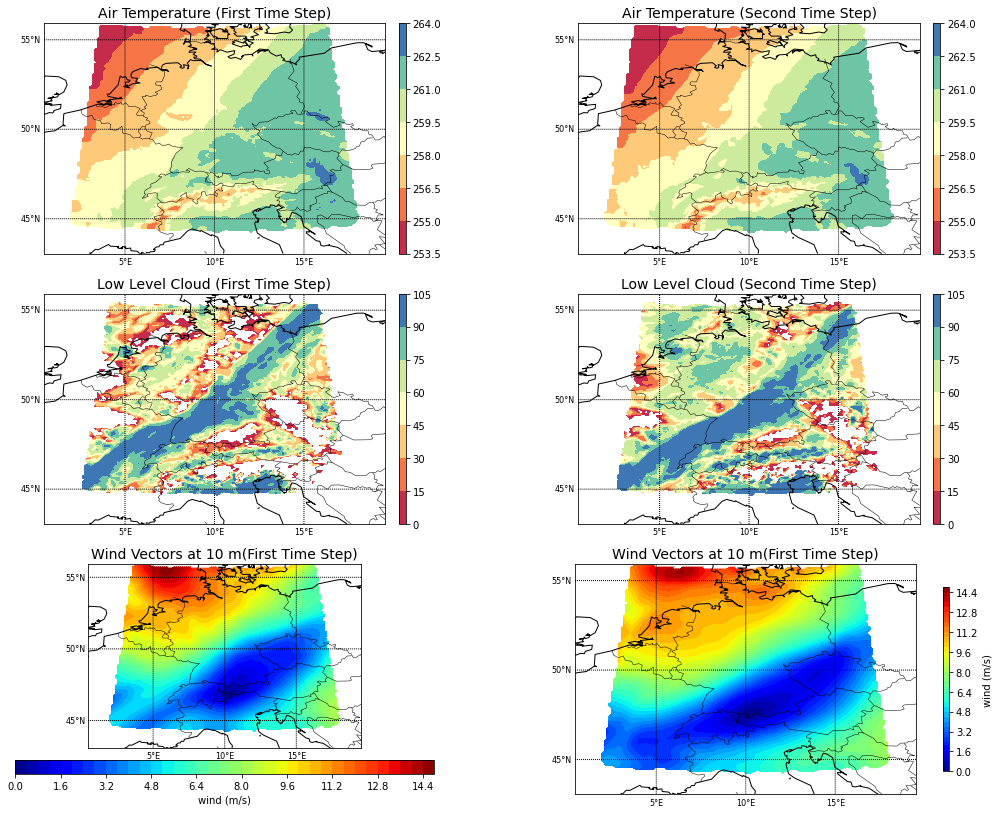

In [5]:
lat = nc.variables['lat'][:,0]
lon = nc.variables['lon'][0,:]
time = nc.variables['time'][:]
h = nc.variables['height'][:]

tmp = nc.variables['temp'][:] # (time, height, lat, lon)   (2, 50, 131, 141) height = generalized height
temp=np.mean(nc.variables['temp'][:], axis=1)
temp[np.abs(temp)==np.abs(0)]=np.NaN
llc = nc.variables['clcl'][:] # (time, plev, lat, lon)     (2, 1, 131, 141)  plev = air pressure (hPa) 
llc[np.abs(llc)==np.abs(0)]=np.NaN
u = nc.variables['u'][:]      # (time, height, lat, lon) (2, 50, 131, 141)
u_mean = np.transpose(np.mean(u, axis=3))
v = nc.variables['v'][:]  # (time, height_4, lat, lon) (2, 50, 131, 141)  height_4 = height
w = nc.variables['w'][:]     # (time, height_2, lat, lon) (2, 51, 131, 141) height_2 = generalized height

fig=plt.figure(figsize=(15,15))

#fig.suptitle("Variables", fontsize=18, fontweight="bold")

fig.add_subplot(421)
plt.title("Air Temperature (First Time Step)", fontsize=14)
map = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(45,60,5),labels=[1,0,0,0],fontsize=8)
map.drawmeridians(np.arange(0,21,5),labels=[0,0,0,1],fontsize=8)
lons,lats= np.meshgrid(lon,lat)
x,y = map(lons,lats)
var = map.contourf(x,y,temp[0,:,:], cmap="Spectral")
cb = map.colorbar(var,"right", size="2%", pad="4%")
plt.tight_layout()

fig.add_subplot(422)
plt.title("Air Temperature (Second Time Step)", fontsize=14)
map = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(45,60,5),labels=[1,0,0,0],fontsize=8)
map.drawmeridians(np.arange(0,21,5),labels=[0,0,0,1],fontsize=8)
lons,lats= np.meshgrid(lon,lat)
x,y = map(lons,lats)
var = map.contourf(x,y,temp[1,:,:], cmap="Spectral")
cb = map.colorbar(var,"right", size="2%", pad="4%")
plt.tight_layout()

fig.add_subplot(423)
plt.title("Low Level Cloud (First Time Step)", fontsize=14)
map = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(45,60,5),labels=[1,0,0,0],fontsize=8)
map.drawmeridians(np.arange(0,21,5),labels=[0,0,0,1],fontsize=8)
lons,lats= np.meshgrid(lon,lat)
x,y = map(lons,lats)
var = map.contourf(x,y,llc[0,0,:,:], cmap="Spectral")
cb = map.colorbar(var,"right", size="2%", pad="4%")
plt.tight_layout()

fig.add_subplot(424)
plt.title("Low Level Cloud (Second Time Step)", fontsize=14)
map = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(45,60,5),labels=[1,0,0,0],fontsize=8)
map.drawmeridians(np.arange(0,21,5),labels=[0,0,0,1],fontsize=8)
lons,lats= np.meshgrid(lon,lat)
x,y = map(lons,lats)
var = map.contourf(x,y,llc[1,0,:,:], cmap="Spectral")
cb = map.colorbar(var,"right", size="2%", pad="4%")
plt.tight_layout()

fig.add_subplot(425)
plt.title("Wind Vectors at 10 m(First Time Step)", fontsize=14)
map = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(45,60,5),labels=[1,0,0,0],fontsize=8)
map.drawmeridians(np.arange(0,21,5),labels=[0,0,0,1],fontsize=8)
lons,lats= np.meshgrid(lon,lat)
x,y = map(lons,lats)
u=nc.variables['u'][0,0,:,:]
u[np.abs(u)==np.abs(0)]=np.NaN
v=nc.variables['v'][0,0,:,:]
v[np.abs(v)==np.abs(0)]=np.NaN
speed=np.sqrt(u*u+v*v)
map.quiver(x,y,u,v,speed,cmap="jet",latlon=True)
cb=map.contourf(x, y, speed, cmap="jet",levels=40)
plt.colorbar(cb, location="bottom",label="wind (m/s)", pad=0.05, shrink=0.8, aspect=30)
plt.tight_layout()

fig.add_subplot(426)
plt.title("Wind Vectors at 10 m(First Time Step)", fontsize=14)
map = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(45,60,5),labels=[1,0,0,0],fontsize=8)
map.drawmeridians(np.arange(0,21,5),labels=[0,0,0,1],fontsize=8)
lons,lats= np.meshgrid(lon,lat)
x,y = map(lons,lats)
u=nc.variables['u'][1,0,:,:]
u[np.abs(u)==np.abs(0)]=np.NaN
v=nc.variables['v'][1,0,:,:]
v[np.abs(v)==np.abs(0)]=np.NaN
speed=np.sqrt(u*u+v*v)
map.quiver(x,y,u,v,speed,cmap="jet",latlon=True)
cb=map.contourf(lons, lats, speed, cmap="jet",levels=40)
plt.colorbar(cb, location="right",label="wind (m/s)", pad=0.05, shrink=0.8, aspect=30)
plt.tight_layout()

plt.show();
#fig.savefig(path+'tmp, llc and wind.png',facecolor='white')